In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
from gviz import draw_dot
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None # Empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Value) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward            
        return out
    
    def __radd__(self, other: Value) -> Value:
        return self + other
    
    def __neg__(self) -> Value:
        return self * -1
        
    def __sub__(self, other: Value) -> Value:
        return self + (-other)
    
    def __rsub__(self, other:Value) -> Value:
        return other + (-self)
    
    def __mul__(self, other: Value) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad            
        out._backward = _backward
        return out
    
    def __rmul__(self, other: Value) -> Value:
        return self * other        
            
    def __truediv__(self, other: Value) -> Value:
        return self * (other ** -1)
    
    def __pow__(self, other: Value) -> Value:
        assert isinstance(other, (int, float)), "Supports only int/float powers"
        out += Value(self.data ** other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
    def exp(self) -> Value:
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    
    def tanh(self) -> Value:
        x = self.data
        t = (math.exp(2.0 * x) - 1.0) / (math.exp(2.0 * x) + 1.0)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1.0 - t ** 2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


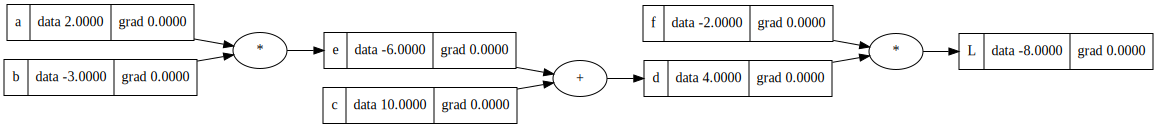

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
draw_dot(L)

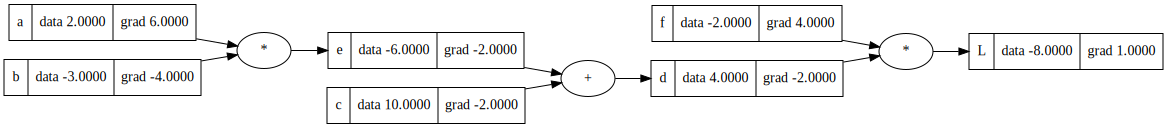

In [4]:
L.grad = 1.0
L.backward()
draw_dot(L)

In [5]:
def grad_numerical_chk():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data


    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2- L1) / h)

grad_numerical_chk()

6.000000000021544


In [6]:
# To make L more positive, we need to nudge leaf nodes viz., a, b, c, f in the direction of gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Now run fprop again to get updated L value
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


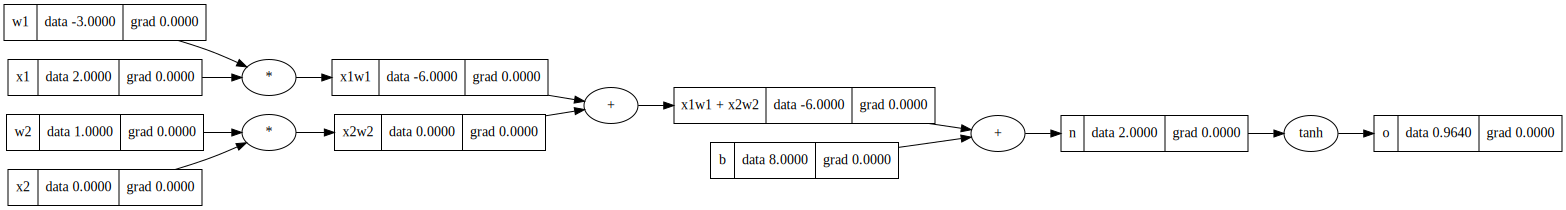

In [7]:
# Build a simple neuron which accepts x1 and x2 as inputs, has weights w1, w2 and bias b. Its activation function is tanh
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(8.0, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)


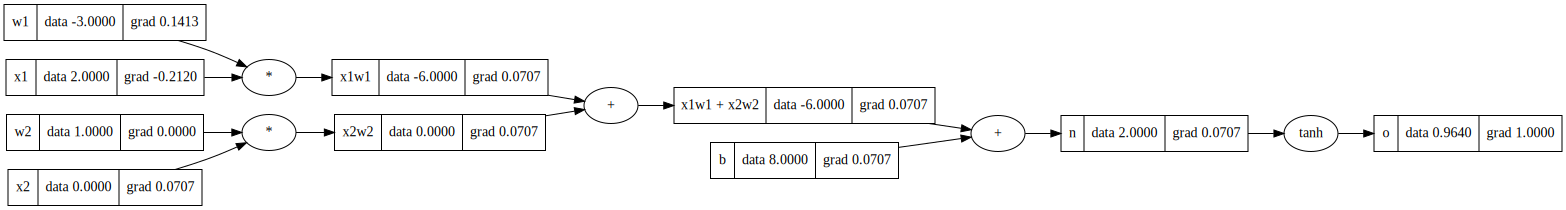

In [8]:
o.grad = 1.0
o.backward()
draw_dot(o)

In [18]:
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



In [24]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4072814685771173),
 Value(data=-0.16969652158525414),
 Value(data=-0.6969739353601876),
 Value(data=0.5662182827699804)]

In [25]:
loss = sum((yout -ytgt) for yout, ytgt in zip(ypred, ys))
print(loss)

Value(data=0.106829294401656)


In [26]:
loss.backward()

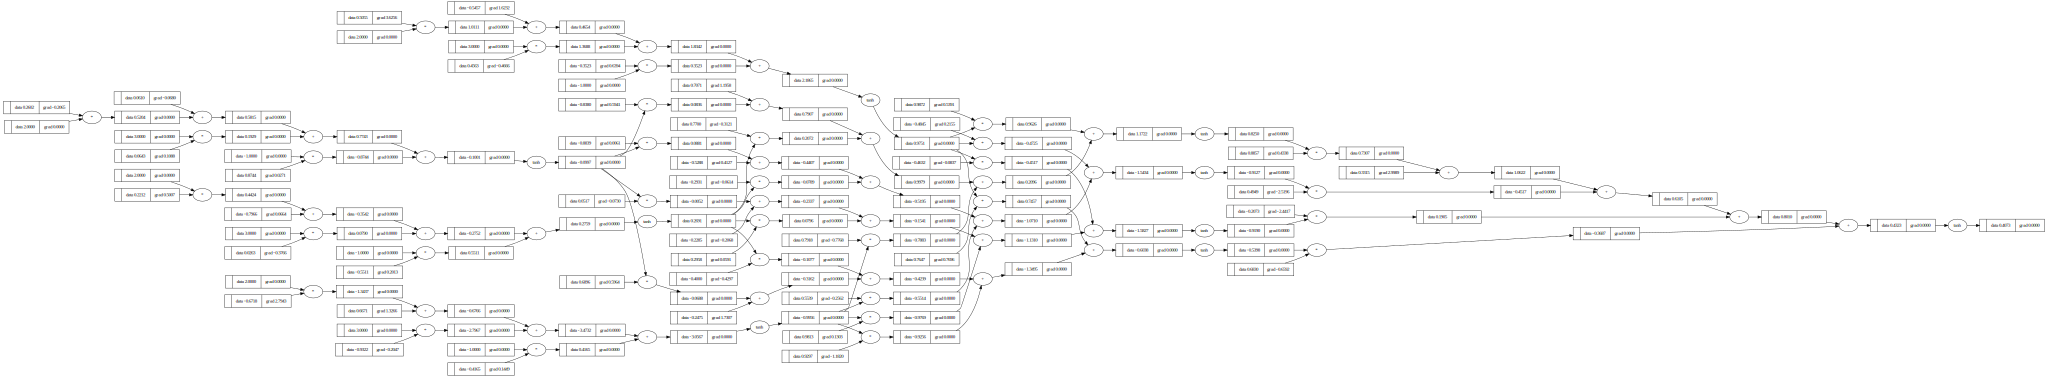

In [27]:
draw_dot(n(x))